In [547]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import itertools
import copy

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
parts = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/particles")

display(hits)


,event_id,x,y,z,energy
0,2850,-18.087435,-16.718485,-56.659714,0.002350
1,2850,-18.657701,-16.599083,-56.539867,0.001025
2,2850,-18.864998,-16.991850,-56.300049,0.007050
3,2850,-17.799454,-17.023008,-56.126163,0.003775
4,2850,-17.549644,-17.638756,-55.878799,0.001375
...,...,...,...,...,...
9343386,7299,-59.810055,-108.992561,1.571673,0.001250
9343387,7299,-60.376736,-104.863922,1.703859,0.001950
9343388,7299,-59.974476,-107.960136,1.788791,0.002325
9343389,7299,-60.275055,-106.016663,1.985682,0.003150


Energy Sum:  2.457875


,x,y,z,energy
0,-192.277847,30.907209,51.784283,0.004825
1,-192.038681,31.331900,51.251160,0.005725
2,-191.819229,30.170366,52.178677,0.003650
3,-191.705521,31.628536,50.941162,0.004550
4,-191.345169,29.865465,51.814041,0.003500
...,...,...,...,...
859,2058.446533,-94.079285,124.364365,0.001850
860,2058.696289,-94.253487,123.879204,0.007475
861,2058.729492,-95.881393,123.304085,0.002175
862,2058.824951,-94.609436,123.551315,0.002550


Vertex Index is: 359
{359: [365, 369], 365: [359, 354], 369: [359, 381], 0: [1, 2], 1: [0, 3], 3: [1, 6], 2: [4, 0], 4: [2, 5], 5: [7, 4], 7: [5], 6: [3, 8], 8: [9, 6], 9: [8, 10], 10: [9, 11], 11: [20, 10], 20: [11, 18], 12: [16, 15], 16: [12, 17], 13: [22, 14], 22: [13, 19], 14: [18, 13], 18: [14, 20], 15: [12, 19], 17: [16, 21], 19: [15, 22], 21: [17, 23], 23: [24, 21], 24: [23, 25], 25: [24, 26], 26: [25, 27], 27: [26, 28], 28: [34, 27], 34: [28, 46], 29: [30, 31], 30: [29, 33], 33: [30, 35], 31: [32, 29], 32: [31, 36], 46: [34, 49], 35: [40, 33], 40: [35, 43], 36: [39, 32], 39: [36, 47], 37: [42, 38], 42: [37, 44], 38: [41, 37], 41: [38, 43], 43: [40, 41], 44: [42, 45], 45: [44, 48], 47: [39, 51], 48: [45, 50], 49: [46, 52], 50: [53, 48], 53: [50, 54], 51: [47, 57], 52: [49, 58], 54: [53, 61], 55: [60, 56], 60: [55, 63], 56: [59, 55], 59: [56, 62], 57: [68, 51], 68: [57, 89], 58: [69, 52], 69: [58, 86], 63: [60, 81], 61: [67, 54], 67: [61, 72], 62: [65, 59], 65: [62, 82], 64: [87,

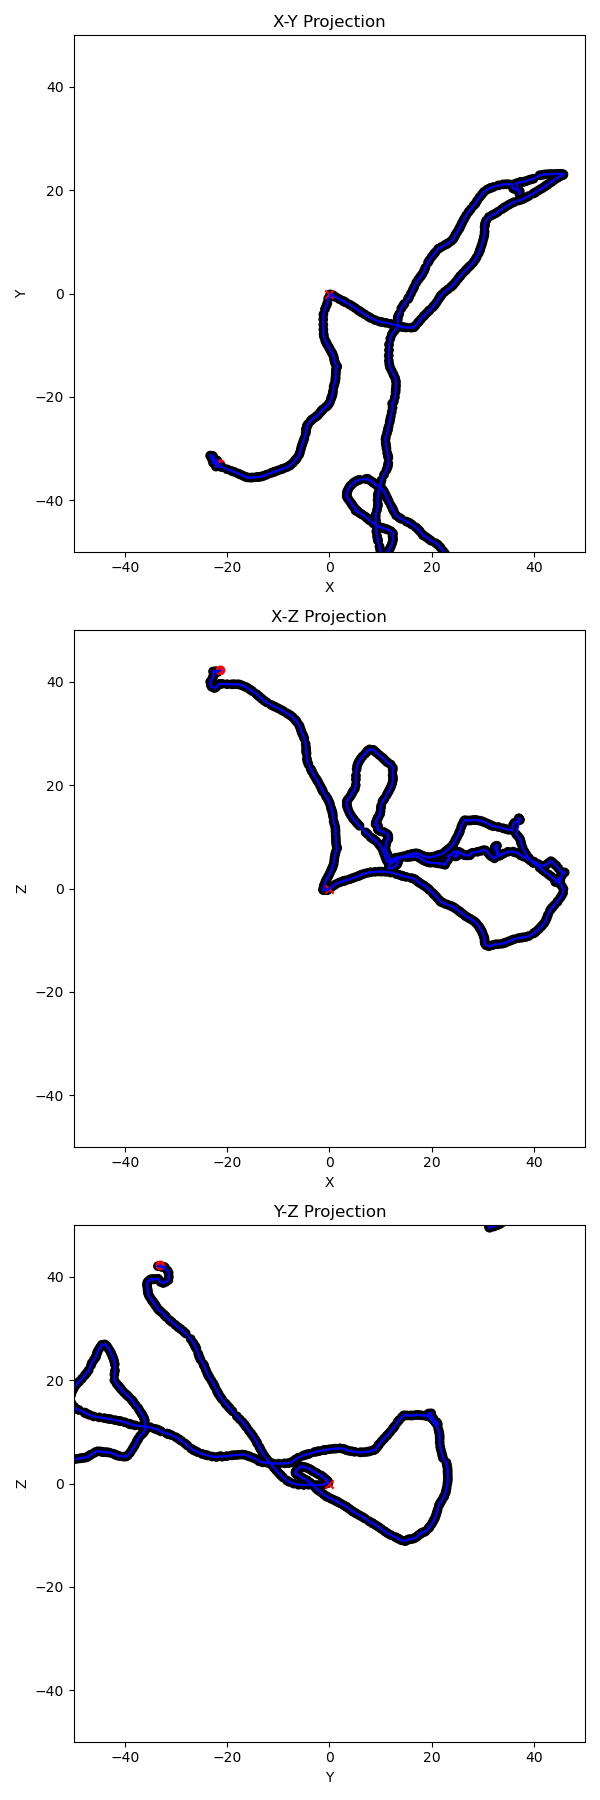

In [548]:
%matplotlib widget

event_num = 79

data = hits[hits.event_id == event_num]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Print energy sum
print("Energy Sum: ", data.energy.sum())

display(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):

    # We shouldnt be doing any self connection
    if (curr_node_idx == conn_node_idx):
        return

    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if curr_node_idx in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node
    prev_node = node 
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    

# Helper function for testing for closed loops
def Testcycle(curr_node, conn_node ,connected_nodes_, connections_, connection_count_):

    # Temporarily add the connection to check for cycles
    temp_connections_dict = copy.deepcopy(connected_nodes_)
    temp_connections      = copy.deepcopy(connections_)
    temp_connection_count = copy.deepcopy(connection_count_)

    # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
    UpdateConnections(curr_node, conn_node, temp_connections_dict, temp_connections, temp_connection_count)

    # Check for cycles
    cycle = forms_cycle(curr_node, conn_node, temp_connections_dict)

    temp_connections_dict = {}
    temp_connections = []
    temp_connection_count = []

    return cycle


connections = []

# -----------------------------------
# Find the node that is closest to the vertex
# Calculate the Euclidean distance from the origin for each row
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
vertex_index = data['distance'].idxmin()
# data = data.drop(columns=['distance'])
print("Vertex Index is:" , vertex_index)

# Make a connection to the two closest nodes
closest_idx = np.argsort(dist_matrix[vertex_index])[1:3]
UpdateConnections(vertex_index, closest_idx[0], connected_nodes, connections, connection_count)
UpdateConnections(vertex_index, closest_idx[1], connected_nodes, connections, connection_count)

# ------------------------------------
# Find closest nodes and create connections

for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break

print(connected_nodes)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    ax.scatter(0, 0, c="r", marker='x')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

# # Plot in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
# ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
# for connection in connections:
#     start_node = connection[0]
#     end_node = connection[1]
#     ax.plot([data['x'][start_node], data['x'][end_node]],
#             [data['y'][start_node], data['y'][end_node]],
#             [data['z'][start_node], data['z'][end_node]], 'b-')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Projection')
# plt.show()

{'id': 0, 'start': 7, 'end': 257, 'nodes': [7, 5, 4, 2, 0, 1, 3, 6, 8, 9, 10, 11, 20, 18, 14, 13, 22, 19, 15, 12, 16, 17, 21, 23, 24, 25, 26, 27, 28, 34, 46, 49, 52, 58, 69, 86, 97, 113, 120, 132, 133, 129, 128, 126, 121, 115, 105, 99, 77, 76, 75, 70, 71, 85, 82, 65, 62, 59, 56, 55, 60, 63, 81, 94, 96, 102, 110, 117, 123, 131, 136, 140, 148, 153, 166, 174, 179, 183, 187, 193, 198, 202, 203, 207, 210, 213, 216, 221, 224, 226, 231, 234, 236, 239, 242, 244, 245, 247, 248, 250, 260, 251, 252, 253, 256, 258, 259, 262, 263, 264, 266, 265, 261, 255, 254, 249, 246, 241, 240, 237, 235, 232, 230, 228, 225, 222, 218, 214, 206, 200, 197, 176, 161, 139, 125, 114, 106, 100, 89, 68, 57, 51, 47, 39, 36, 32, 31, 29, 30, 33, 35, 40, 43, 41, 38, 37, 42, 44, 45, 48, 50, 53, 54, 61, 67, 72, 84, 83, 80, 79, 78, 74, 73, 66, 64, 87, 101, 107, 109, 112, 118, 122, 124, 130, 134, 138, 141, 154, 163, 169, 172, 177, 184, 191, 192, 196, 194, 190, 188, 186, 182, 181, 178, 175, 171, 170, 167, 164, 158, 155, 152, 146,

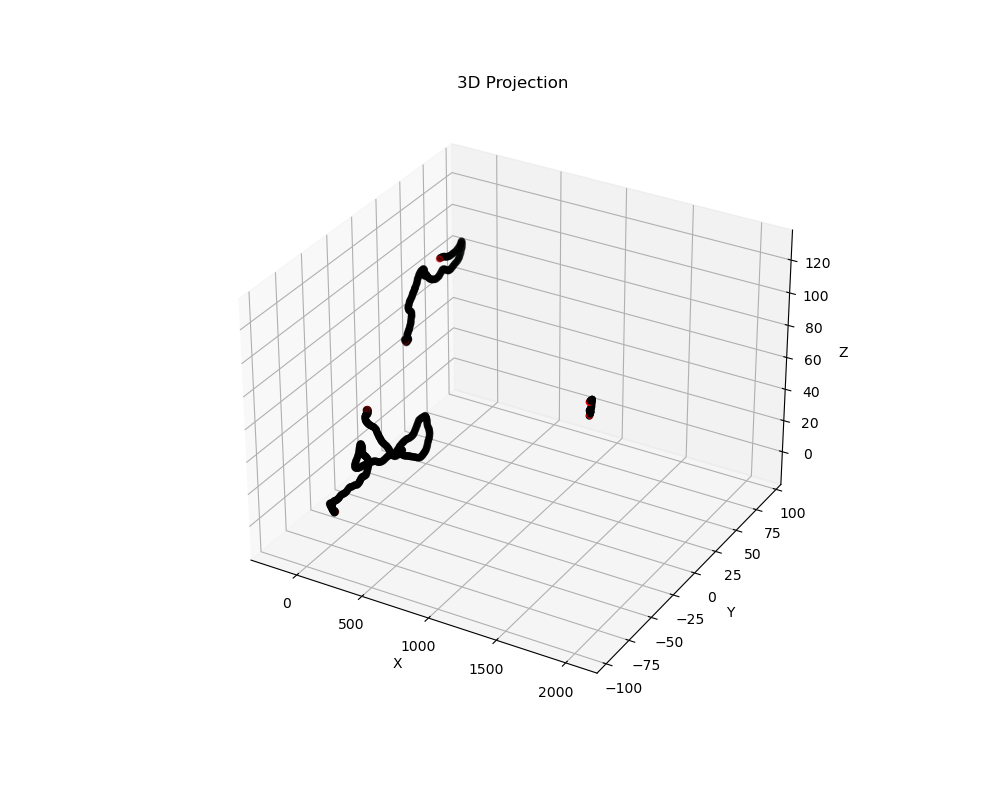

In [549]:
# Track building

# Function to walk along a track segment till we get to an end
def GetNodePath(graph, start_node, forward_node):
    path = [start_node]
    
    query = forward_node
    prev_node = start_node 

    for index,n in enumerate(range(len(graph))):

        path.append(query)
        
        # Get the connected nodes
        con_nodes = graph[query]

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return path

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]


    print("Error in pathing...")
    return path

def check_start_end_exists(number,Tracks):
    check_start = any(path["start"] == number for path in Tracks)
    check_end = any(path["end"] == number for path in Tracks)

    if (check_start or check_end):
        return True
    else:
        return False

# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point2['x'] - point1['x'])**2 + (point2['y'] - point1['y'])**2 + (point2['z'] - point1['z'])**2)

# Get the length and energy of a track
def GetTrackLengthEnergy(path):
    total_length = 0
    total_energy = 0

    # Return the hit if there is only one node
    if len(path) == 0:
        return 0,data.iloc[path[0]]['energy']

    for t in range(len(path) - 1):
        point1 = data.iloc[path[t]]
        point2 = data.iloc[path[t + 1]]
        
        distance = calculate_distance(point1, point2)
        total_length += distance
        total_energy += point1['energy']
    
    # Add in the last energy hit
    total_energy += data.iloc[path[-1]]['energy']

    return round(total_length, 3), total_energy
    # return round(total_length, 3), round(total_energy, 3)


# Get the length and energy of a track
def GetMeanNodeDist(Tracks):

    nodedists = []

    for track in Tracks:

        nodes = track["nodes"]
        if (len(nodes) == 1):
            continue

        for n in range(len(nodes) - 1):

            point1 = data.iloc[nodes[n]]
            point2 = data.iloc[nodes[n + 1]]
            
            distance = calculate_distance(point1, point2)
            nodedists.append(distance)

    return round(np.mean(nodedists), 3)


colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in Tracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

# print(Tracks[1]["nodes"])
# print(GetNodePath(connected_nodes, 32, 27))
# print(GetNodePath(connected_nodes, 32, 41))


In [550]:
print(GetMeanNodeDist(Tracks))

dist_threshold = 4*GetMeanNodeDist(Tracks)
# dist_threshold = 10

0.68


vertex: 359
Path1: [359, 365, 354, 351, 348, 344, 341, 338, 339, 340, 342, 343, 345, 347, 349, 352, 355, 358, 361, 363, 367, 371, 372, 374, 375, 380, 386, 385, 384, 383, 382, 379, 378, 377, 376, 373, 370, 368, 366, 364, 362, 360, 357, 356, 353, 350, 346, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 280, 279, 276, 274, 269, 268, 267, 270, 272, 271, 273, 277, 278, 275, 281]
Path2: [359, 369, 381, 387, 388, 389, 390, 399, 404, 409, 418, 421, 423, 425, 431, 434, 438, 460, 471, 486, 518, 549, 556, 560, 562, 564, 571, 574, 576, 579, 582, 585, 590, 592, 595, 597, 600, 603, 605, 606, 609, 612, 614, 616, 618, 620, 626, 635, 637, 640, 650, 660, 665, 667, 671, 677, 679, 681, 688, 691, 693, 695, 698, 700, 701, 702, 705, 706, 708, 710, 712, 711, 713, 714, 716, 719, 72

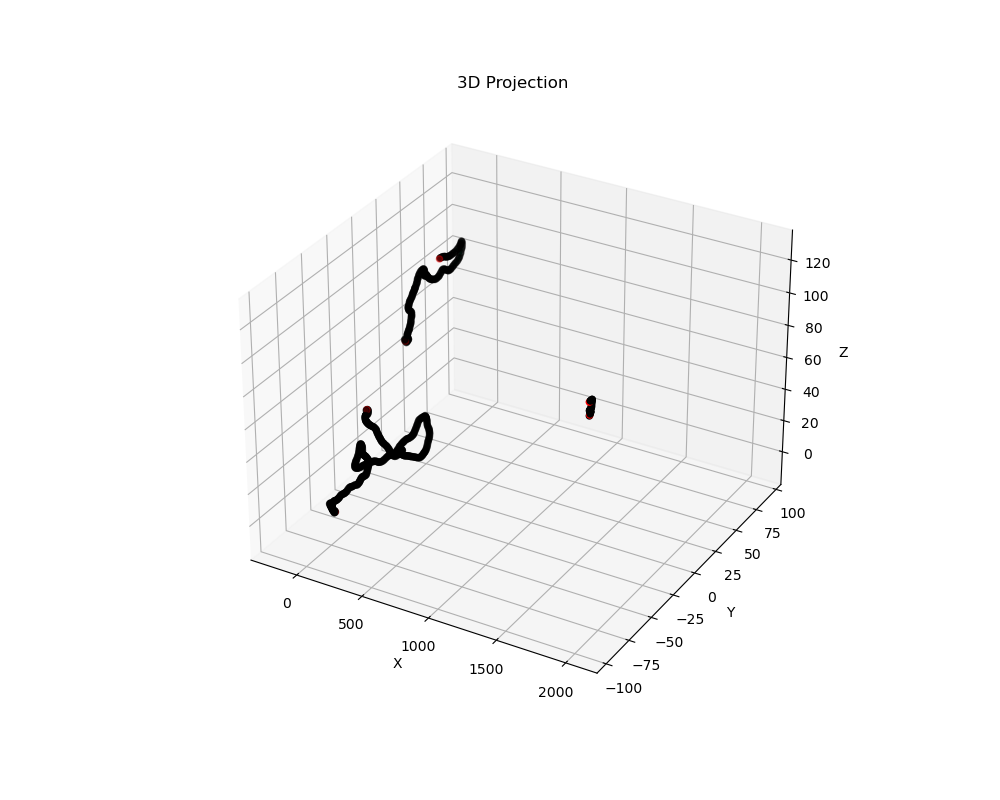

In [551]:
# Now look to merge tracks that are close by and identify deltas

def GetTrackwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t["id"]
    # The node wasnt found anywhere...
    return -1

def GetTrackDictwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t
    # The node wasnt found anywhere...
    return -1

def join_tracks(array1, array2):
    # Check if the arrays can be joined directly
    if array1[-1] == array2[0]:
        joined_array = array1 + array2[1:]
    elif array1[0] == array2[-1]:
        joined_array = array2 + array1[1:]
    # Check if reversing one of the arrays allows them to be joined
    elif array1[-1] == array2[-1]:
        array2_reversed = array2[::-1]
        joined_array = array1 + array2_reversed[1:]
    elif array1[0] == array2[0]:
        array1_reversed = array1[::-1]
        joined_array = array1_reversed + array2[1:]
    else:
        print("Error cannot join arrays")
        joined_array = array1 + array2  # If they can't be joined, just concatenate them

    return joined_array

# This is
def AddConnectedTracks(curr_track,conn_track, delta_path, seg1_path, seg2_path, UpdatedTracks):

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # remove the old tracks
        if (t["id"] == conn_track):
            UpdatedTracks.pop(index)


    delta_len, delta_e = GetTrackLengthEnergy(delta_path)
    Delta = {"id":GetUniqueTrackID(UpdatedTracks), "start":delta_path[0], "end":delta_path[-1], "nodes":delta_path, "length":delta_len, "energy":delta_e,"label":"delta","c":"darkred"}
    UpdatedTracks.append(Delta)
    
    joined_track_path = join_tracks(seg1_path, seg2_path)
    total_length_joined, total_energy_joined = GetTrackLengthEnergy(joined_track_path)
    color = next(color_cycle)
    
    Primary = {"id":GetUniqueTrackID(UpdatedTracks), "start":joined_track_path[0], "end":joined_track_path[-1], "nodes":joined_track_path, "length":total_length_joined, "energy":total_energy_joined,"label":"track","c":color}
    UpdatedTracks.append(Primary)

# This adds the same track ID for the delta and the joining track
def AddConnectedTracksnoDelta(curr_track,conn_track, track1_path, UpdatedTracks):

    print("Joining tracks ",curr_track,", ",conn_track)
    name = "track"

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            if (t["label"] == "Track1" or t["label"] == "Track2"):
                name = t["label"]
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # Get the same colour as the track
        if (t["id"] == conn_track):
            color = t["c"]
            
            if (t["label"] == "Track1" or t["label"] == "Track2"):
                name = t["label"]

    print("Label is: ", name)

    track1_len, track1_e = GetTrackLengthEnergy(track1_path)
    Track1 = {"id":conn_track, "start":track1_path[0], "end":track1_path[-1], "nodes":track1_path, "length":track1_len, "energy":track1_e,"label":name,"c":color}
    UpdatedTracks.append(Track1)

# From the track containing the vertex, split the track and add a single node for the vertex
def CreateVertexandSplit(vertexid, trackid, track1_path, track2_path, Tracks):

    # Remove the old tracks from the array
    for index, t in enumerate(Tracks):
        # remove the old track
        if (t["id"] == trackid):
            print("Killing Track: ",t["id"])
            Tracks.pop(index)

    track1_len, track1_e = GetTrackLengthEnergy(track1_path)
    track2_len, track2_e = GetTrackLengthEnergy(track2_path)
    vertex_len, vertex_e = GetTrackLengthEnergy([vertexid])

    color = next(color_cycle)
    Track1 = {"id":GetUniqueTrackID(Tracks), "start":track1_path[0], "end":track1_path[-1], "nodes":track1_path, "length":track1_len, "energy":track1_e,"label":"Track1","c":color}
    Tracks.append(Track1)

    color = next(color_cycle)
    Track2 = {"id":GetUniqueTrackID(Tracks), "start":track2_path[0], "end":track2_path[-1], "nodes":track2_path, "length":track2_len, "energy":track2_e,"label":"Track2","c":color}
    Tracks.append(Track2)

    Vertex = {"id":GetUniqueTrackID(Tracks), "start":vertexid, "end":vertexid, "nodes":[vertexid], "length":vertex_len, "energy":vertex_e,"label":"vertex","c":"r"}
    Tracks.append(Vertex)
   

# Update an existing track in the updated tracks array from the merging of two tracks
def UpdateAndMergeTrack(curr_track,conn_track, newpath, UpdatedTracks_):

    name=""
    
    for index, t in enumerate(UpdatedTracks_):
        
        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks_):
            
            # remove the old tracks
            if (t["id"] == curr_track):
                UpdatedTracks_.pop(index)

        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks_):
            # remove the old tracks
            if (t["id"] == conn_track):
                name=t["label"]
                UpdatedTracks_.pop(index)

    # Add the new merged track
    length, energy = GetTrackLengthEnergy(newpath)
    print(newpath[0], newpath[-1], newpath)
    color = next(color_cycle)
    Primary = {"id":GetUniqueTrackID(UpdatedTracks_), "start":newpath[0], "end":newpath[-1], "nodes":newpath, "length":length, "energy":energy,"label":name,"c":color}
    UpdatedTracks_.append(Primary)


def SearchDelta(Track_, UpdatedTracks_):
    start = Track_["start"]
    end   = Track_["end"]

    for index, t in enumerate(UpdatedTracks_):
        
        # Check to see if the current track ends matches with any tracks in the updated and it is flagged as a delta
        if (t["start"] == start or t["start"] == end or t["end"] == start or t["end"] == end):
            if (t["label"] == "delta"):
                return True
        
    return False


def GetUniqueTrackID(Tracks_):

    temp_track_id = -1

    for t in Tracks_:
        if temp_track_id <= t["id"]:
            temp_track_id = t["id"]

    print("New Track ID is:",temp_track_id+1)

    return temp_track_id+1



# Any nodes without a connection can be re-added as a track
def AddConnectionlessNodes(connection_count, UpdatedTracks):

    for index, c in enumerate(connection_count):

        if (c == 0):
            hit_energy = data.iloc[index].energy
            Gamma = {"id":GetUniqueTrackID(UpdatedTracks), "start":index, "end":index, "nodes":[index], "length":0, "energy":hit_energy,"label":"gamma","c":"y"}
            UpdatedTracks.append(Gamma)

# First function doesnt account for duplicate nodes. We fix that here
# also distribute the vertex energy equally among track 1 and track 2
def FixTrackEnergies(UpdatedTracks,vertex_index):

    counted_nodes = []

    vertex_half_energy = 0
    for t in UpdatedTracks:
        if (t["label"] == "vertex"):
            vertex_half_energy = data.iloc[t["start"]].energy/2.0
            counted_nodes.append(t["start"])

    # Get the total energy
    for t in UpdatedTracks:
        e_sum = 0

        for node in t["nodes"]:
            if (node in counted_nodes):
                continue
                
            counted_nodes.append(node)

            e_node = data.iloc[node].energy
            e_sum = e_sum + e_node
        
        # Split the energy equally
        if (t["label"] == "Track1" or t["label"] == "Track2"):
            
            # only do it for the track next to the vertex as there can be merged deltas
            if (vertex_index in t["nodes"]):
                e_sum = e_sum + vertex_half_energy
        
        # remove energy from the vertex
        if (t["label"] == "vertex"):
            e_sum=0

        t["energy"] = e_sum


# ------------------------------------------------------
# Here we break the track containing the vertex ID in two 
for t in Tracks:

    # Found the track with the vertex
    if (vertex_index in t["nodes"]):
        # Get the length either side of track
        trk1_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][0])[0:]
        trk2_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][1])[0:]
        print("vertex:",vertex_index)
        print("Path1:",trk1_path)
        print("Path2:",trk2_path)
        CreateVertexandSplit(vertex_index, t["id"], trk1_path, trk2_path, Tracks)
        break

print("Printing Tracks")
for t in Tracks:
    print(t)

# ------------------------------------------------------

# UpdatedTracks = []
UpdatedTracks = copy.deepcopy(Tracks)

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    print("Num new tracks:", len(UpdatedTracks))

    if (Track["label"] == "vertex"):
        print("Skipping Vertex...")
        continue
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Choose the smallest index
    if dist_start < dist_end:
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Skip if we are trying to reconnect to a vertex
    if (end_conn_node == vertex_index):
        print("Trying to connect to vertex, skipping...")
        continue


    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)

    # if node-node then merge nodes and update track in Tracks
    if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
         
       newpath = join_tracks(curr_track_path,con_track_dict["nodes"])
       UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks)
       UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
       print("node-node connection")
       continue

    # Check if the proposed connection will form a cycle
    cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
    else:
        break

    # Combine the tracks
    AddConnectedTracksnoDelta(curr_track, con_track, Track["nodes"], UpdatedTracks)



# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, UpdatedTracks)
FixTrackEnergies(UpdatedTracks,vertex_index)


e_sum = 0
track_id_list = []
for t in UpdatedTracks:
    print(t)
    if t["id"] not in track_id_list:
        track_id_list.append(t["id"])

        
    e_sum+=t["energy"]

print("Tot Energy: ",e_sum)
print("Total Tracks:", len(UpdatedTracks))
print("Total Unique:", len(track_id_list))

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



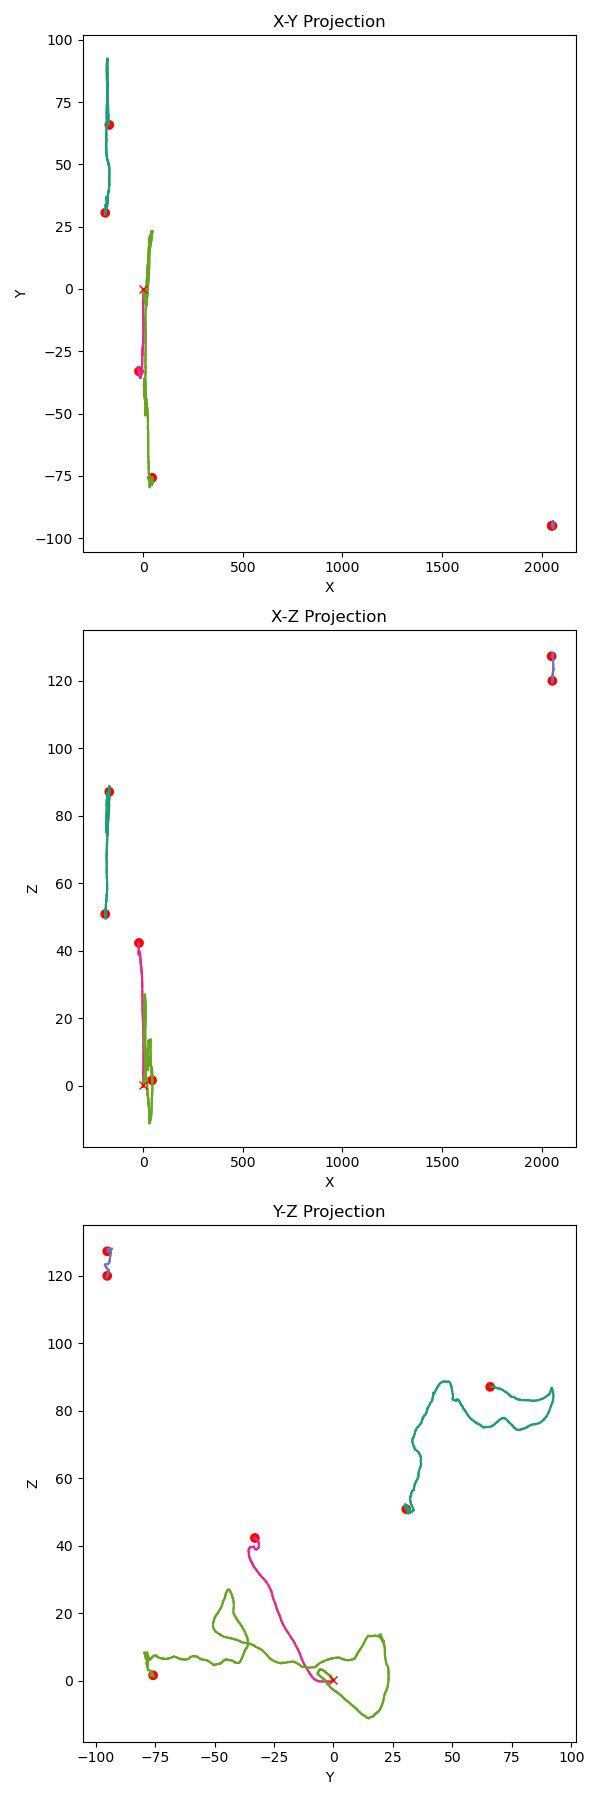

In [552]:
# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # Define colors for filtered data
    colors = ['r' if connection_count[i] == 1 else 'Orange' for i in filtered_indices]
    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in UpdatedTracks:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y')

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z')

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

In [553]:
# Reconstruction level quantities

# Add gamma energy to the lowest energy track

track1_energy = 0
track2_energy = 0

for t in UpdatedTracks:

    if (t["label"] == "Track1"):
        track1_energy = track1_energy + t["energy"]

    if (t["label"] == "Track2"):
        track2_energy = track2_energy + t["energy"]

# ID the track with the lowest label
highest_track = "Track2"
if (track1_energy > track2_energy):
    highest_track = "Track1"

e_gammas = 0
for t in UpdatedTracks:

    if (t["label"] != "Track1" and t["label"] != "Track2"):
        print(t["label"])
        e_gammas = e_gammas + t["energy"]

print("Gamma Energy:",e_gammas)

if (highest_track == "Track1"):
    track1_energy = track1_energy + e_gammas
else:
    track2_energy = track2_energy + e_gammas

print("Track 1 Energy:", track1_energy)
print("Track 2 Energy:", track2_energy)
print("Tot Energy:", track1_energy + track2_energy)


part = parts[parts.event_id == event_num]
part = part[part.primary == 1]
display(part)

gen_kin_energy = max(part.kin_energy.values) # generator T1

track
track
vertex
Gamma Energy: 0.9282250017276965
Track 1 Energy: 0.3284374983068119
Track 2 Energy: 2.1294375002853485
Tot Energy: 2.4578749985921604


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
12555,79,2,e-,1,0,0.0,0.0,0.0,0.0,45.479870,...,1.218472,-0.519392,0.959332,-0.0,0.0,0.0,1.202442,313.774109,none,eIoni
12565,79,1,e-,1,0,0.0,0.0,0.0,0.0,-21.783209,...,-0.478037,-1.572791,-0.396749,0.0,0.0,0.0,1.255557,89.344101,none,eIoni


In [554]:
# Calculate the angle between the electrons

# Calculate the angle between momentum vectors
def calculate_angle_parts(row):
    # Extract momentum components for particle 1
    p1 = np.array([row['initial_momentum_x_1'], row['initial_momentum_y_1'], row['initial_momentum_z_1']])
    # Extract momentum components for particle 2
    p2 = np.array([row['initial_momentum_x_2'], row['initial_momentum_y_2'], row['initial_momentum_z_2']])
    
    # Calculate dot product and magnitudes
    dot_product = np.dot(p1, p2)
    magnitude_p1 = np.linalg.norm(p1)
    magnitude_p2 = np.linalg.norm(p2)
    
    # Calculate the cosine of the angle
    cos_theta = dot_product / (magnitude_p1 * magnitude_p2)
    
    # Ensure the value is within the valid range for arccos (to avoid numerical errors)
    cos_theta = np.clip(cos_theta, -1, 1)
    
    # Calculate the angle in radians
    # angle = np.arccos(cos_theta)
    
    return cos_theta


### ------------- ------------- ------------- -------------
# Filter particles with particle_id 1 and 2
particle_1 = part[part.particle_id == 1].copy()
particle_2 = part[part.particle_id == 2].copy()

# Merge the DataFrames on 'event' to pair particles from the same event
merged_particles = pd.merge(particle_1, particle_2, on="event_id", suffixes=('_1', '_2'))

# Apply the function to each row in the merged DataFrame
merged_particles['angle'] = merged_particles.apply(calculate_angle_parts, axis=1)
print("True Angle:", merged_particles['angle'].iloc[0])
# ------------- ------------- ------------- -------------

data['Track1'] = 0
data['Track2'] = 0

track1_indices = []
track2_indices = []

for t in UpdatedTracks:

    if t["label"] == "Track1":
        track1_indices = track1_indices + t["nodes"]

    if t["label"] == "Track2":
        track2_indices = track2_indices + t["nodes"]

data.loc[track1_indices, 'Track1'] = 1
data.loc[track2_indices, 'Track2'] = 1

display(data[data.distance < 5])


True Angle: -0.05286081796450358


,x,y,z,energy,distance,Track1,Track2
341,-1.159723,-4.054760,-0.233228,0.001900,4.223794,1,0
344,-0.846795,-2.998378,-0.264399,0.002100,3.126857,1,0
348,-0.562155,-2.328719,-0.305082,0.000725,2.414958,1,0
351,-0.387227,-1.857539,-0.309489,0.001375,1.922545,1,0
354,-0.218864,-0.975130,-0.193375,0.001300,1.017927,1,0
359,0.169433,-0.161829,0.114506,0.002075,0.260783,1,1
365,0.605873,-0.291407,0.421460,0.000750,0.793491,1,0
369,0.814484,-0.402550,0.562331,0.000225,1.068479,0,1
381,1.268963,-0.707236,0.844666,0.000525,1.680450,0,1
387,1.983213,-1.095499,1.178868,0.004425,2.554013,0,1


In [555]:
def cosine_angle(vector_a, vector_b):
    # Compute the dot product of the two vectors
    dot_product = np.dot(vector_a, vector_b)
    
    # Compute the magnitudes (norms) of the vectors
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (norm_a * norm_b)
    
    return cos_theta

# Given vertex position
vertex = data[ (data.Track1 == 1) & (data.Track2 == 1)]
vertex = np.array([vertex.iloc[0].x,vertex.iloc[0].y,vertex.iloc[0].z])

Track1 = data[ (data.Track1 == 1) & (data.Track2 != 1)]
Track1 = Track1.reindex(track1_indices)


Track2 = data[ (data.Track2 == 1) & (data.Track1 != 1)]
Track2 = Track2.reindex(track2_indices)

display(Track1)
display(Track2)

len_Track1 = len(Track1)
len_Track2 = len(Track2)
cos_theta1 = 2; cos_theta2 = 2; cos_theta3 = 2

Track1_node1 = np.array(Track1.iloc[1][0:3])
Track2_node1 = np.array(Track2.iloc[1][0:3])

if (len_Track1 > 1):
    Track1_node2 = np.array(Track1.iloc[2][0:3])

if (len_Track2 > 1):
    Track2_node2 = np.array(Track2.iloc[2][0:3])

direction_vector1 = Track1_node1 - vertex
direction_vector2 = Track2_node1 - vertex

if (len_Track1 > 1):
    direction_vector3 = Track1_node2 - vertex

if (len_Track2 > 1):
    direction_vector4 = Track2_node2 - vertex

# # Compute cosine of the angle between the vectors
cos_theta1 = cosine_angle(direction_vector1, direction_vector2)

if (len_Track1 > 1):
    cos_theta2 = cosine_angle(direction_vector2, direction_vector3)

if (len_Track2 > 1):
    cos_theta3 = cosine_angle(direction_vector1, direction_vector4)

cos_theta = min([cos_theta1,cos_theta2,cos_theta3], key=abs)

print(cos_theta)

,x,y,z,energy,distance,Track1,Track2
359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,0.605873,-0.291407,0.421460,0.000750,0.793491,1.0,0.0
354,-0.218864,-0.975130,-0.193375,0.001300,1.017927,1.0,0.0
351,-0.387227,-1.857539,-0.309489,0.001375,1.922545,1.0,0.0
348,-0.562155,-2.328719,-0.305082,0.000725,2.414958,1.0,0.0
...,...,...,...,...,...,...,...
273,-22.529348,-32.137272,41.831280,0.002275,57.360542,1.0,0.0
277,-21.901037,-32.350098,41.949905,0.016250,57.323456,1.0,0.0
278,-21.809715,-32.777935,41.952045,0.048575,57.532867,1.0,0.0
275,-22.170151,-33.511108,42.100685,0.001050,58.197746,1.0,0.0


,x,y,z,energy,distance,Track1,Track2
359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,0.814484,-0.402550,0.562331,0.000225,1.068479,0.0,1.0
381,1.268963,-0.707236,0.844666,0.000525,1.680450,0.0,1.0
387,1.983213,-1.095499,1.178868,0.004425,2.554013,0.0,1.0
388,2.643981,-1.425923,1.409923,0.001275,3.318399,0.0,1.0
...,...,...,...,...,...,...,...
819,44.932117,-76.750381,1.410470,0.009325,88.946640,0.0,1.0
822,45.096420,-76.445915,1.437126,0.002350,88.767845,0.0,1.0
820,44.950024,-76.100388,2.094769,0.042700,88.409058,0.0,1.0
812,44.186314,-75.546585,1.264658,0.018825,87.528946,0.0,1.0


-0.2461839834378565


(-5.0, 5.0)

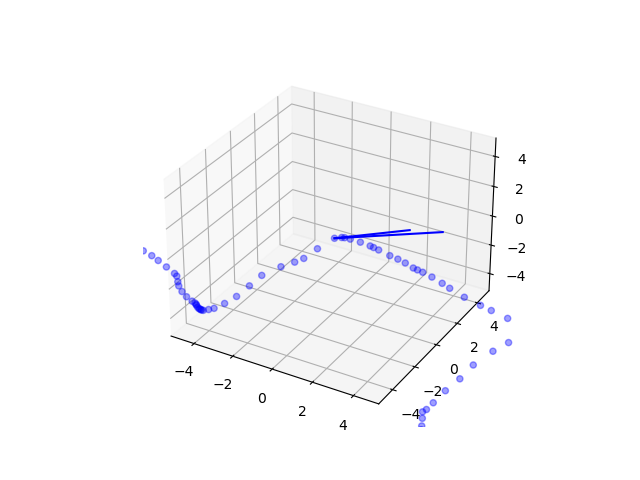

In [556]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
ax.scatter(data.x, data.y, data.z, color='blue')
# ax.scatter(Track2.x, Track2.y, Track2.z, color='green')

# Plot the direction vector
vector_line1 = np.array([vertex, vertex + 10*direction_vector1])  # Extend the vector for visualization
vector_line2 = np.array([vertex, vertex + 10*direction_vector2])  # Extend the vector for visualization

ax.plot(vector_line1[:, 0], vector_line1[:, 1], vector_line1[:, 2], color='blue')
ax.plot(vector_line2[:, 0], vector_line2[:, 1], vector_line2[:, 2], color='blue')

ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)